# **1. Import Libraries and Load Data**

## 1.1 Install Libraries

In [ ]:
!pip install --upgrade numpy scipy GPy GPyOpt

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)


## 1.2 Fetch Data

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

# Fetch S&P 500 ETF (SPY), Gold ETF (GLD)
tickers = ["SPY", "QQQ", "GLD"]
start_date = "2013-01-01"
end_date = "2023-12-31"

data = yf.download(tickers, start=start_date, end=end_date)

prices = data["Close"]

# print(data.head())
print(prices.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


Ticker             GLD        QQQ         SPY
Date                                         
2013-01-02  163.169998  60.452332  117.624870
2013-01-03  161.199997  60.137493  117.359085
2013-01-04  160.440002  59.939568  117.874443
2013-01-07  159.429993  59.957561  117.552368
2013-01-08  160.559998  59.840618  117.214134


## 1.3 Data Pre-Processing

In [ ]:
returns = prices.asfreq('D').interpolate(method='time')

# **2. Bayesian Optimization with GP-Hedge**

## 2.1 Import libraries and data processing

In [ ]:
import numpy as np
import GPyOpt
import GPy
import GPyOpt.models
import GPyOpt.core
from nopast import get_best_evaluation

returns = returns[['GLD', 'QQQ', 'SPY']].values

## 2.2 Define Sharpe Ratio

In [ ]:
def portfolio_sharpe(weights):
    if len(weights.shape) == 1:
        weights = weights.reshape(1, -1)
    sharpe_values = []
    for w in weights:
        w1, w2 = w[0], w[1]
        w3 = 1 - w1 - w2
        if w1 < 0 or w2 < 0 or w3 < 0:
            sharpe = 0
        else:
            # Calculate portfolio returns
            port_ret = returns[:, 0]*w1 + returns[:, 1]*w2 + returns[:, 2]*w3
            mean_ret = port_ret.mean()
            std_ret = port_ret.std()
            sharpe = (mean_ret / std_ret) if std_ret != 0 else 0
            sharpe = -sharpe  # Convert to minimization
        sharpe_values.append(sharpe)
    return np.array(sharpe_values).reshape(-1, 1)

## 2.3 Define Space and Initial Samples

In [ ]:
space = GPyOpt.Design_space([
    {'name': 'w1', 'type': 'continuous', 'domain': (0, 1)},
    {'name': 'w2', 'type': 'continuous', 'domain': (0, 1)},
], constraints=[{'name': 'sum_constraint', 'constraint': 'x[:,0] + x[:,1] <= 1.0'}])

In [ ]:
X_init = np.array([
    [0.333, 0.333],  # Equal weights
    [0.2, 0.4],
    [0.3, 0.5],
    [0.6, 0.2],
])
y_init = portfolio_sharpe(X_init)

## 2.4 Define Acquisition Functions

In [ ]:
acquisitions = [
    {
        'type': 'ei',
        'epsilon': 0.1
    },
    {
        'type': 'pi',
        'epsilon': 0.1
    },
    {
        'type': 'lcb',
        'upsilon': 0.2,
        'delta': 0.1
    },
]

## 2.5 Call For NO_Past_Bayesian Optimization

In [ ]:
evaluations, scores = get_best_evaluation(X_init, y_init, space, acquisitions, portfolio_sharpe, factor=0.7, iterations=100, eta=4)

# **3. Comparision with GP-Hedge Algorithm**

## 3.1 Extract the GP-Hedge Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pickle

load_path = '/content/drive/MyDrive/gp_hedge.pkl'

with open(load_path, 'rb') as f:
    sharpe_results_gp_hedge = pickle.load(f)

load_path = '/content/drive/MyDrive/weights.pkl'

with open(load_path, 'rb') as f:
    best_weights_gp = pickle.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3.2 Convergence Plot

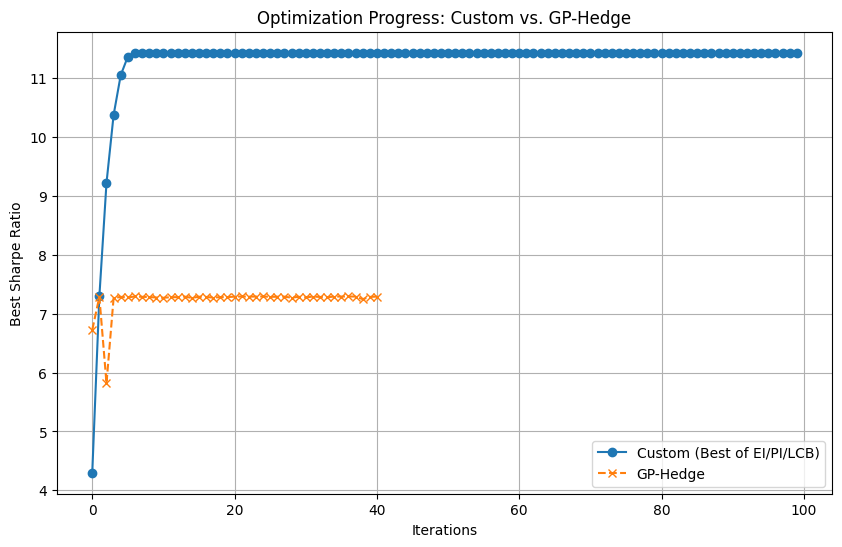

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

best_scores_per_iteration = np.max(scores, axis=1)
# best_cumulative_scores = np.maximum.accumulate(best_scores_per_iterati

# For GP-Hedge
sharpe_gp_hedge = np.array(sharpe_results_gp_hedge)/12

plt.figure(figsize=(10, 6))
plt.plot(best_cumulative_scores, label='Custom (Best of EI/PI/LCB)', marker='o')
plt.plot(sharpe_gp_hedge, label='GP-Hedge', marker='x', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Best Sharpe Ratio')
plt.title('Optimization Progress: Custom vs. GP-Hedge')
plt.legend()
plt.grid(True)
plt.show()

## 3.3 Optimal Weights for both the methods

In [ ]:
# For NO_past_BO
best_idx_custom = np.argmax(best_scores_per_iteration)
best_weights_custom = evaluations[best_idx_custom, :2]
w3_custom = max(0, 1 - best_weights_custom[0] - best_weights_custom[1])


print("Custom Method Optimal Weights:")
print(f"GLD: {best_weights_custom[0]:.4f}, QQQ: {best_weights_custom[1]:.4f}, SPY: {w3_custom:.4f}")

print("\nGP-Hedge Optimal Weights:")
print(f"GLD: {best_weights_gp[0]:.4f}, QQQ: {best_weights_gp[1]:.4f}, SPY: {best_weights_gp[2]:.4f}")

Custom Method Optimal Weights:
GLD: 0.7790, QQQ: 0.2219, SPY: 0.0000

GP-Hedge Optimal Weights:
GLD: 1.0000, QQQ: 0.0000, SPY: 0.0000
